### <font color='#A52A2A'> 1. Process Explanation

Among the different feature extraction methods, our first priority is **MFCC** (Mel-Frequency Cepstral Coefficients). We focus on the first **13** coefficients because they represent the spectral envelope, which contains the most perceptually significant information for sound discrimination.

We decided to use both the **mean and standard** deviation of these coefficients across time frames. The mean provides the average value, while the standard deviation captures the temporal variations, giving us a more comprehensive representation of the audio signal.

We began the project using only MFCCs. Subsequently, we incorporated additional methods to evaluate their impact on classification performance.

Given that our task involves distinguishing between car and tram sounds, we added the following features:

- **Spectral Centroid:** This indicates the "brightness" of a sound. We added it because tram sounds often have a more metallic and higher-pitched character, resulting in a higher spectral centroid compared to cars.

- **RMS (Root Mean Square) Energy:** This measures the average power or loudness of the signal. We included it since trams typically produce more constant and powerful acoustic energy, while car sounds are often more variable in intensity.

- **Zero Crossing Rate (ZCR):** This feature reflects the noisiness or high-frequency content of a signal. It was added because trams frequently exhibit more metallic, high-frequency components in their sound signature compared to cars.

### <font color='#A52A2A'> 2. Import 

In [2]:
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 48.5 MB/s  0:00:00m0:00:01


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### <font color='#A52A2A'> 3. Help Functions
#### <font color='#A52A2A'> 3. 1: Feature Extraction

**Our feature extraction process begins with MFCC as the default method, with additional feature options available to enhance model performance.**

In [23]:
def extract_features_car_tram(y, sr, mfcc_only=True):
    features = []
    
    # 1- MFCC (13 mean + 13 std = 26 features)
    mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features.extend(np.mean(mfcc_features, axis=1))      # 13 features
    features.extend(np.std(mfcc_features, axis=1))       # 13 features
    
    if mfcc_only:
        return np.array(features)
    else:
        # 2- Spectral Centroid (mean + std = 2 features)
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        features.append(np.mean(centroid))          # 1 feature
        features.append(np.std(centroid))           # 1 feature
        
        # 3- RMS (mean + std = 2 features)
        rms = librosa.feature.rms(y=y)
        features.append(np.mean(rms))               # 1 feature
        features.append(np.std(rms))                # 1 feature
        
        # 4- Zero Crossing Rate (1 feature)
        zcr = librosa.feature.zero_crossing_rate(y)
        features.append(np.mean(zcr))               # 1 feature
        
        return np.array(features)   
    

def extract_features(file_paths):
    """
    Extract features from one or multiple audio files
    
    Parameters:
    - file_paths: single file path (str) or list of file paths
    
    Returns:
    - numpy array of shape (n_files, 31) for multiple files
    - numpy array of shape (31,) for single file
    """
    
    # Handle single file path
    if isinstance(file_paths, str):
        y, sr = librosa.load(file_paths) #, sr=22050
        y = librosa.util.normalize(y)
        return extract_features_car_tram(y, sr)
    
    # Handle multiple files
    result = []
    for file_path in file_paths:
        y, sr = librosa.load(file_path, sr=22050)  #, sr=22050
        y = librosa.util.normalize(y)
        features = extract_features_car_tram(y, sr)
        result.append(features)
    
    return np.array(result)

#### <font color='#A52A2A'> 3. 2: Load Dataset

**Load all audio samples, extract their features, and return combined arrays of features and corresponding labels.**

In [ ]:
def load_dataset(data_folder):
    """
    Create a complete dataset from folder structure:
    data_folder/
    ├── car/
    │   ├── audio1.wav
    │   └── audio2.wav
    └── tram/
        ├── audio1.wav
        └── audio2.wav
    """
    features = []
    labels = []
    
    for class_name in ['car', 'tram']:
        class_folder = os.path.join(data_folder, class_name)
        
        if not os.path.exists(class_folder):
            continue
            
        for audio_file in os.listdir(class_folder):
            if audio_file.endswith('.wav'):
                file_path = os.path.join(class_folder, audio_file)
                feature_vector = extract_features(file_path)
                
                if feature_vector is not None:
                    features.append(feature_vector)
                    labels.append(class_name)
    
    return np.array(features), np.array(labels)

#### <font color='#A52A2A'> 3. 3: Train the Dataset

**Using various machine learning models including:**
- SVM,
- Logistic Regression,
- KNN,
- Random Forest,
- Gradient Boosting,
- Naive Bayes, and
- MLP classifiers.

In [47]:
def train_and_evaluate(model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    model_name: string → one of:
      "svm", "logreg", "knn", "rf", "gb", "nb", "mlp"
    scaled: if True → use scaled data (good for SVM, logreg, KNN, MLP)
    """
    
    X_train_input = X_train
    X_val_input   = X_val
    X_test_input  = X_test

    # 1. Create model based on name --------------------------------------
    if model_name == "svm":
        model = SVC(kernel="linear", probability=True)

    elif model_name == "logreg":
        model = LogisticRegression(max_iter=2000)

    elif model_name == "knn":
        model = KNeighborsClassifier(n_neighbors=5)

    elif model_name == "rf":
        model = RandomForestClassifier(n_estimators=200, random_state=42)

    elif model_name == "gb":
        model = GradientBoostingClassifier()

    elif model_name == "nb":
        model = GaussianNB()

    elif model_name == "mlp":
        model = MLPClassifier(hidden_layer_sizes=(128, 64),
                              max_iter=1000,
                              random_state=42)
    else:
        raise ValueError(f"Unknown model name: {model_name}")


    # 2. Train on training data --------------------------------------
    model.fit(X_train_input, y_train)

    # 3. Evaluate on validation data --------------------------------------
    y_pred_val = model.predict(X_val_input)
    val_acc = accuracy_score(y_val, y_pred_val)

    # 4. Evaluate final performance on test data --------------------------------------
    y_pred_test = model.predict(X_test_input)

    test_acc = accuracy_score(y_test, y_pred_test)
    test_prec = precision_score(y_test, y_pred_test, pos_label="car")
    test_rec = recall_score(y_test, y_pred_test, pos_label="car")

    # Return everything
    result_df = pd.DataFrame([{
        "Model": model_name,
        "Validation Accuracy": val_acc,
        "Test Accuracy": test_acc,
        "Precision (car)": test_prec,
        "Recall (car)": test_rec
    }])

    return result_df, model


#### <font color='#A52A2A'> 3. 3: ROC Plot

**Generate ROC curves to compare false positive rates against true positive rates across all models in a single visualization.**

In [61]:
def plot_all_roc_curves_enhanced(trained_models, X_test, y_test, model_names=None):
    """
    Enhanced version with better colors and styling
    """
    plt.figure(figsize=(8, 6))
    
    if model_names is None:
        model_names = [type(model).__name__ for model in trained_models]
    
    # Convert labels to binary (assuming "car" is positive class)
    y_test_binary = (y_test == "car").astype(int)
    
    # Define colors for different models
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    
    # Store AUC values for ranking
    auc_scores = []
    
    for i, model in enumerate(trained_models):
        if not hasattr(model, "predict_proba"):
            print(f"{model_names[i]} does NOT support probability output. Skipping ROC.")
            continue

        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob)
        roc_auc = auc(fpr, tpr)
        auc_scores.append((model_names[i], roc_auc))

        plt.plot(fpr, tpr, 
                color=colors[i % len(colors)],
                linewidth=2.5,
                label=f'{model_names[i]} (AUC = {roc_auc:.3f})')
    
    # Sort models by AUC score for better legend
    auc_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, linewidth=1, label='Random (AUC = 0.500)')
    
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("ROC Curves Comparison - Car vs Tram Classification", fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(alpha=0.2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    # Add performance summary
    best_model, best_auc = auc_scores[0] if auc_scores else ("None", 0)
    plt.text(0.60, 0.15, 
             f'Best Model: {best_model} (AUC = {best_auc:.3f})\nTest Samples: {len(X_test)}', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9),
             fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print AUC ranking
    print("\n📊 Model Performance Ranking (by AUC):")
    print("-" * 40)
    for rank, (model_name, auc_score) in enumerate(auc_scores, 1):
        print(f"{rank:2d}. {model_name:15} AUC = {auc_score:.3f}")


### <font color='#A52A2A'> 4. Execute the function and analyze the output.

#### <font color='#A52A2A'> 4. 1: Display the feature vector for an individual sample and the dimensions of the complete dataset.

In [37]:
features_single_audio = extract_features("data/car/770683__joolkas__14car.wav")
print(f"Single file features shape: {features_single_audio.shape}")
print(f"Single file MFCC's features:\n {features_single_audio}")
print(35*'-')

DATA_PATH = "data/"
X, y = load_dataset(DATA_PATH)
print(f"Dataset shape: {X.shape}")
print(f"Labels: {np.unique(y)}") 


Single file features shape: (26,)

Single file MFCC's features:
 [-70.481575  115.13974   -40.750153    5.7649174   0.9499958  17.265944
   5.969877   12.198985   -1.119793    2.219457   -4.2855654   2.9657521
  -2.6277857  56.597797    6.988771    9.4782715  10.453823    5.5376143
   3.8364193   4.719107    3.8732097   4.7327414   4.1581564   3.8992808
   3.5817652   3.9224625]
--------------------------------------------------------------------------------
Dataset shape: (32, 26)
Labels: ['car' 'tram']


#### <font color='#A52A2A'> 4. 2: Split the data

**Partition the dataset with randomized shuffling to prevent ordering biases, utilize validation data for training monitoring, and implement random seed initialization for result reproducibility.**

In [42]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, stratify=y_temp, random_state=42)

In [44]:
# Print all splits for complete verification
print("=== DATA SPLIT VERIFICATION ===")
print(f"Original data: X {X.shape}, y {y.shape}")
print(f"Train data:    X {X_train.shape}, y {y_train.shape} which is {len(X_train)/len(X)*100:.1f}% of whole data")
print(f"Validation:    X {X_val.shape}, y {y_val.shape} which is {len(X_val)/len(X)*100:.1f}% of whole data")
print(f"Test data:     X {X_test.shape}, y {y_test.shape} which is {len(X_test)/len(X)*100:.1f}% of whole data")

# Verify they sum to 100%
total_percent = (len(X_train) + len(X_val) + len(X_test)) / len(X) * 100
print(f"\nTotal: {total_percent:.1f}%")

# Verify class distribution
print("\n=== CLASS DISTRIBUTION ===")
print(f"Original - Car: {(y == 'car').mean()*100:.1f}%, Tram: {(y == 'tram').mean()*100:.1f}%")
print(f"Train    - Car: {(y_train == 'car').mean()*100:.1f}%, Tram: {(y_train == 'tram').mean()*100:.1f}%")
print(f"Val      - Car: {(y_val == 'car').mean()*100:.1f}%, Tram: {(y_val == 'tram').mean()*100:.1f}%")
print(f"Test     - Car: {(y_test == 'car').mean()*100:.1f}%, Tram: {(y_test == 'tram').mean()*100:.1f}%")


=== DATA SPLIT VERIFICATION ===
Original data: X (32, 26), y (32,)
Train data:    X (22, 26), y (22,) which is 68.8% of whole data
Validation:    X (5, 26), y (5,) which is 15.6% of whole data
Test data:     X (5, 26), y (5,) which is 15.6% of whole data

Total: 100.0% (Should be 100.0%)

=== CLASS DISTRIBUTION ===
Original - Car: 53.1%, Tram: 46.9%
Train    - Car: 54.5%, Tram: 45.5%
Val      - Car: 40.0%, Tram: 60.0%
Test     - Car: 60.0%, Tram: 40.0%


#### <font color='#A52A2A'> 4. 3: Execute model training and conduct comprehensive performance comparison across all algorithms.

In [56]:
all_results = []  
model_names = []
trained_models = []

models = ["svm", "logreg", "knn", "rf", "gb", "nb", "mlp"]

for ml in models:
    table, _ = train_and_evaluate(
        ml,
        X_train, y_train,
        X_val, y_val,
        X_test, y_test
    )
    all_results.append(table)
    trained_models.append(model)
    model_names.append(ml.upper())

# Combine all results into one big table
final_table = pd.concat(all_results, ignore_index=True)

print(final_table)


    Model  Validation Accuracy  Test Accuracy  Precision (car)  Recall (car)
0     svm                  1.0            1.0              1.0      1.000000
1  logreg                  1.0            1.0              1.0      1.000000
2     knn                  1.0            0.8              1.0      0.666667
3      rf                  1.0            1.0              1.0      1.000000
4      gb                  1.0            1.0              1.0      1.000000
5      nb                  1.0            1.0              1.0      1.000000
6     mlp                  1.0            1.0              1.0      1.000000


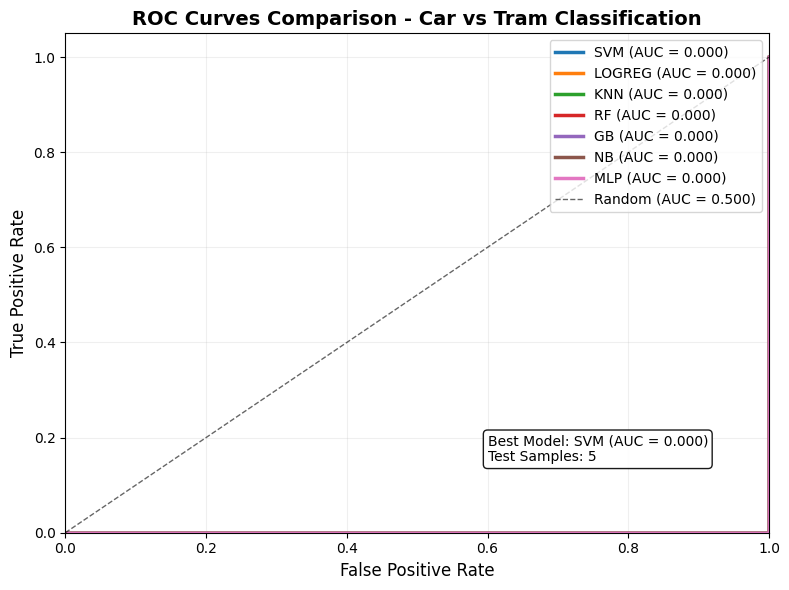


📊 Model Performance Ranking (by AUC):
----------------------------------------
 1. SVM             AUC = 0.000
 2. LOGREG          AUC = 0.000
 3. KNN             AUC = 0.000
 4. RF              AUC = 0.000
 5. GB              AUC = 0.000
 6. NB              AUC = 0.000
 7. MLP             AUC = 0.000


In [62]:
plot_all_roc_curves_enhanced(trained_models, X_test, y_test, model_names)

#### <font color='#A52A2A'> 5: Try to improve the model by adding more features.